## Project Goals
Our project seeks to analyze health-related datasets focusing on diabetes, aiming to uncover insights into how various health conditions contribute to the diagnosis of diabetes. This analysis will cover how various health metrics relate to diabetes diagnoses. Values range from macroscopic (e.g. gender, age) to microscopic (e.g. blood glucose level), additionally including common risk factors, like history of heart disease and smoking. Following basic exploratory analysis, PCA is applied to reduce data dimensionality for clustering analysis that could potentially categorize individuals based on their likelihood of developing diabetes.

## Import Section

In [1]:
from utilities import ProjectDataFrame, ProjNormalizedDF, LogisticModel, one_hot_encoder

## 1 Data Loading and Dataset Overview

In [2]:
DATA_PATH = "diabetes_prediction_dataset.csv"
INVASIVES = ['HbA1c_level', 'blood_glucose_level']
RANDOM_STATE = 42 # for reproducibility
projectdf = ProjectDataFrame(DATA_PATH, random_state=RANDOM_STATE)

In [3]:
projectdf.dataset_overview()

,Missing Values,Unique Values,Count,Mean,Std,Min,Max
Gender,18,2,99982,NaN,NaN,NaN,NaN
Age,0,102,100000,41.8859,22.5168,0.0800,80.0000
Hypertension,0,2,100000,0.0748,0.2632,0.0000,1.0000
Heart Disease,0,2,100000,0.0394,0.1946,0.0000,1.0000
Smoking History,35816,5,64184,NaN,NaN,NaN,NaN
Bmi,0,4247,100000,27.3208,6.6368,10.0100,95.6900
Hba1c Level,0,18,100000,5.5275,1.0707,3.5000,9.0000
Blood Glucose Level,0,18,100000,138.0581,40.7081,80.0000,300.0000
Diabetes,0,2,100000,0.0850,0.2789,0.0000,1.0000


## 2 Categorical Features Inspection

diabetes,0,1
gender,,
Female,54091,4461
Male,37391,4039


diabetes,0,1
hypertension,,
0,86103,6412
1,5397,2088


diabetes,0,1
heart_disease,,
0,88825,7233
1,2675,1267


diabetes,0,1
smoking_history,,
current,8338,948
ever,3532,472
former,7762,1590
never,31749,3346
not current,5757,690


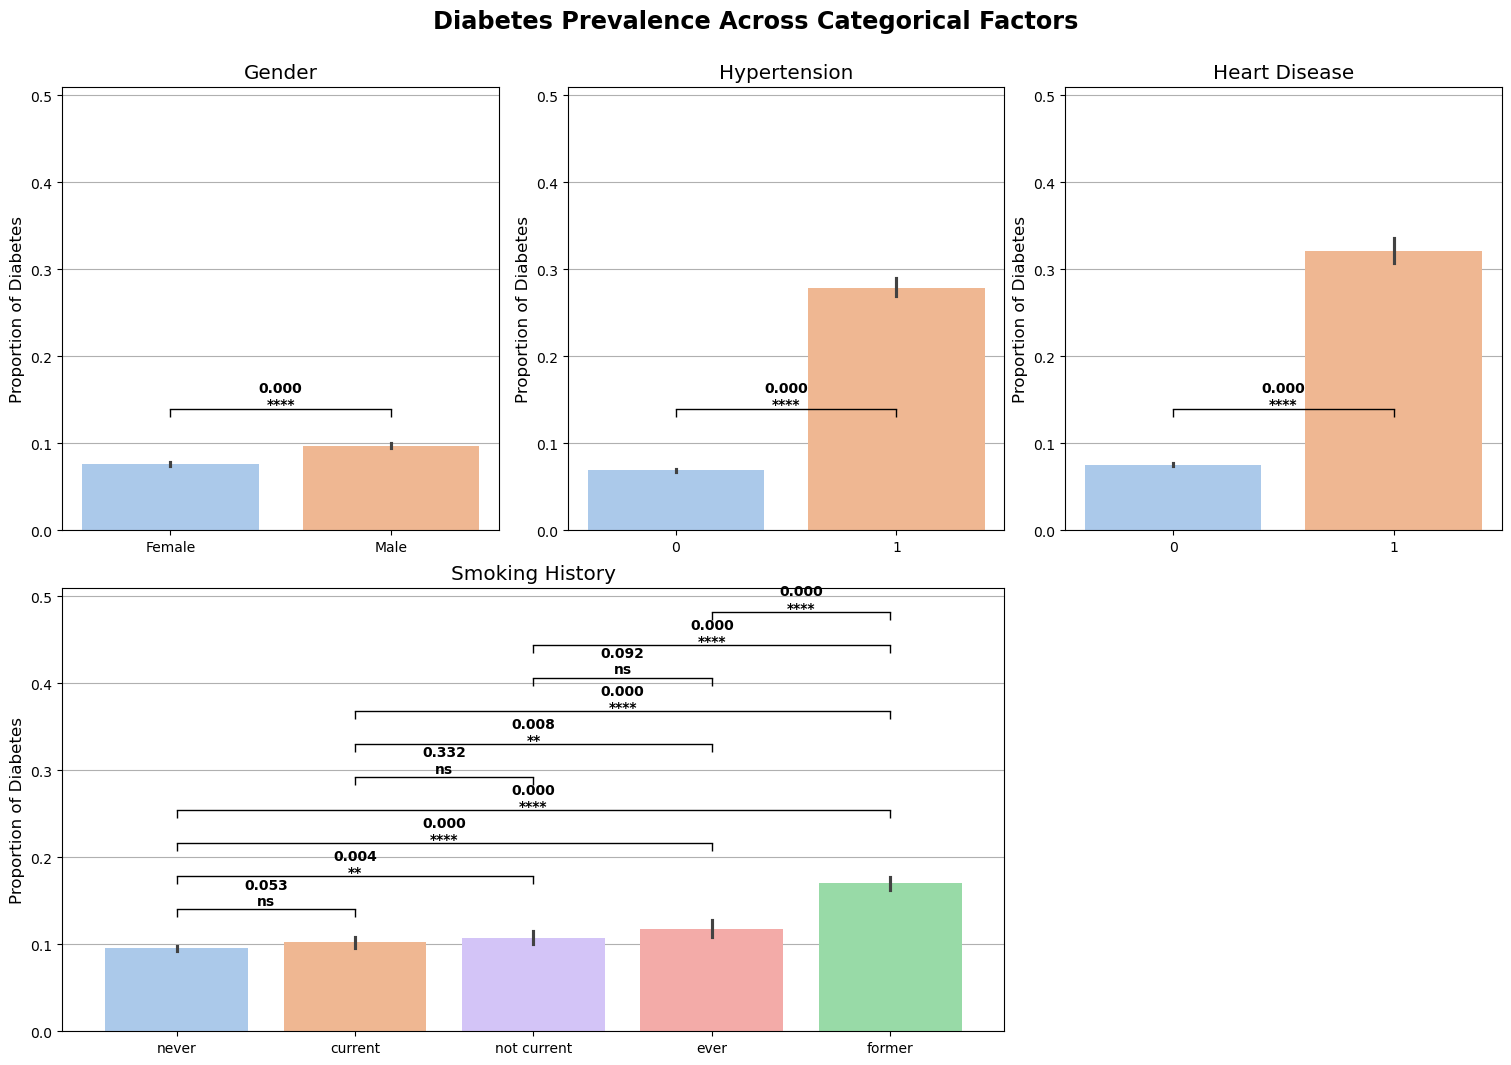

In [4]:
projectdf.categoricals_inspection()

## 3 Numericals Inspection

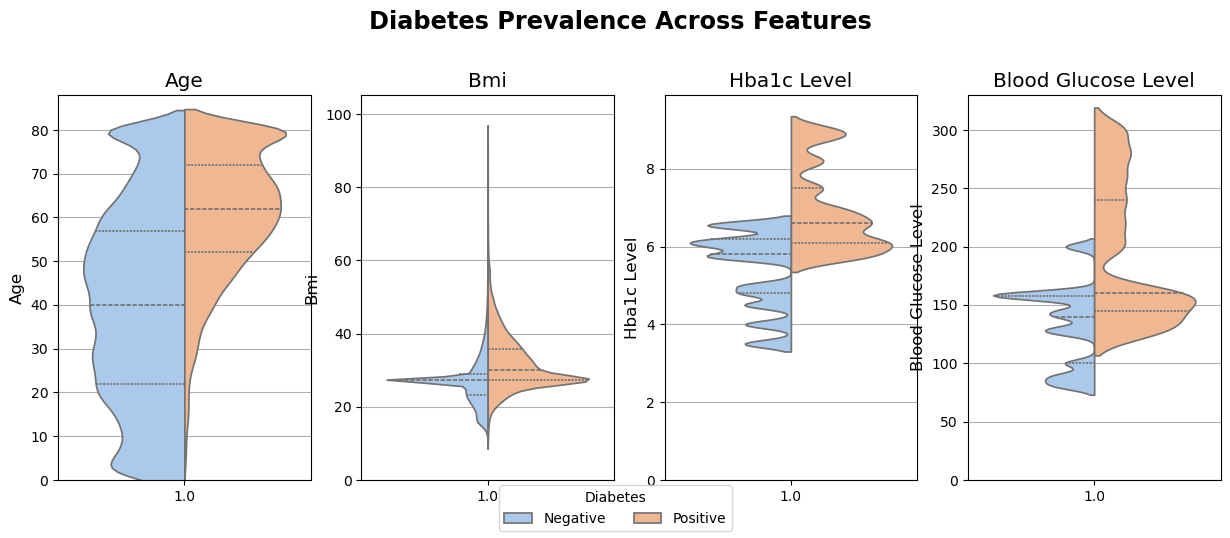

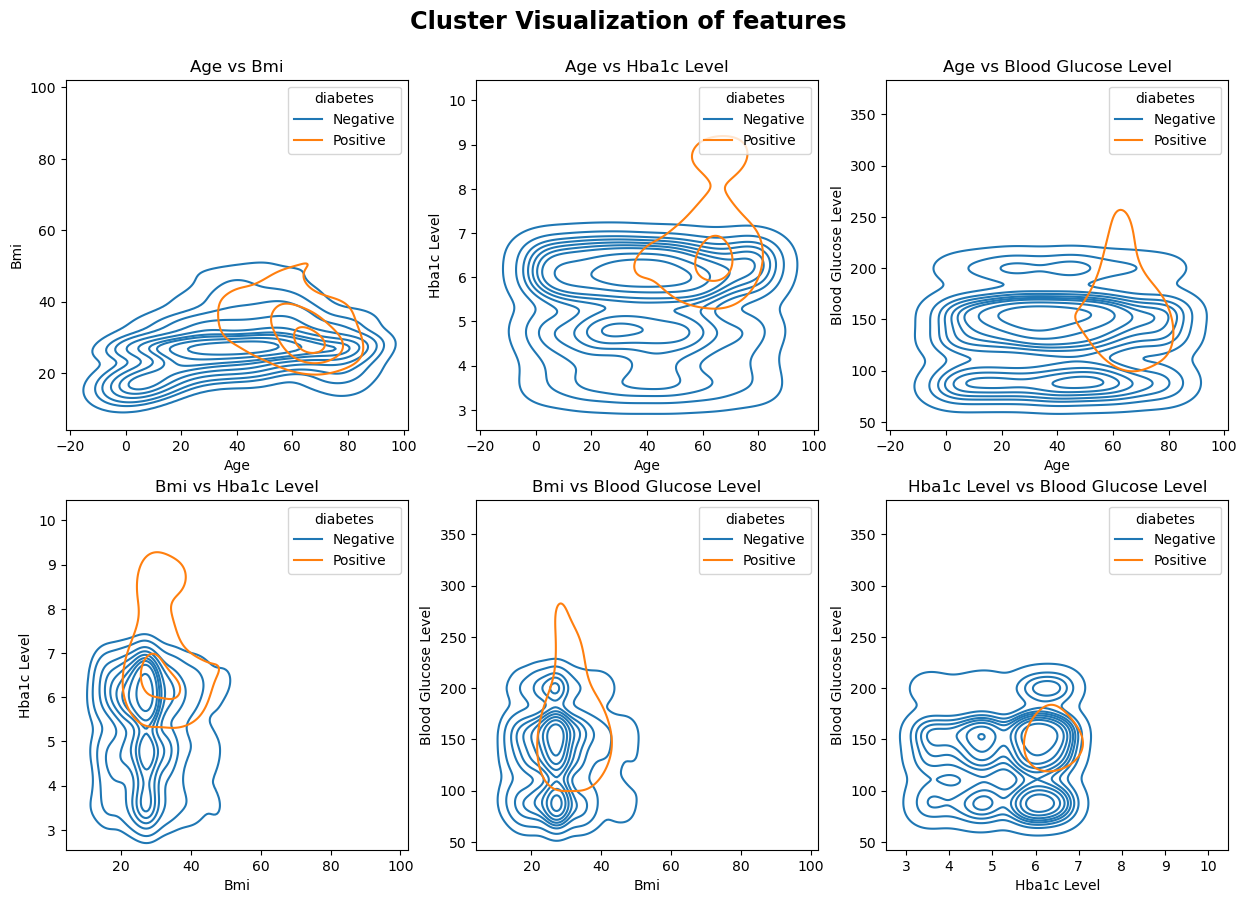

,df,sum_sq,mean_sq,F,PR(>F)
age,1.0000,54.3559,54.3559,787.4364,0.0000
bmi,1.0000,17.2000,17.2000,249.1706,0.0000
age:bmi,1.0000,26.9534,26.9534,390.4647,0.0000
Residual,9996.0000,690.0138,0.0690,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
age,1.0000,54.3559,54.3559,952.2471,0.0000
HbA1c_level,1.0000,109.0665,109.0665,1910.7061,0.0000
age:HbA1c_level,1.0000,54.5114,54.5114,954.9709,0.0000
Residual,9996.0000,570.5893,0.0571,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
age,1.0000,54.3559,54.3559,957.1918,0.0000
blood_glucose_level,1.0000,125.1869,125.1869,2204.5029,0.0000
age:blood_glucose_level,1.0000,41.3386,41.3386,727.9605,0.0000
Residual,9996.0000,567.6417,0.0568,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
bmi,1.0000,40.1812,40.1812,667.3011,0.0000
HbA1c_level,1.0000,115.4053,115.4053,1916.5706,0.0000
bmi:HbA1c_level,1.0000,31.0324,31.0324,515.3640,0.0000
Residual,9996.0000,601.9042,0.0602,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
bmi,1.0000,40.1812,40.1812,672.3313,0.0000
blood_glucose_level,1.0000,130.6018,130.6018,2185.2919,0.0000
bmi:blood_glucose_level,1.0000,20.3393,20.3393,340.3268,0.0000
Residual,9996.0000,597.4008,0.0598,NaN,NaN


,df,sum_sq,mean_sq,F,PR(>F)
HbA1c_level,1.0000,126.0498,126.0498,2473.3501,0.0000
blood_glucose_level,1.0000,102.8184,102.8184,2017.5026,0.0000
HbA1c_level:blood_glucose_level,1.0000,50.2268,50.2268,985.5507,0.0000
Residual,9996.0000,509.4281,0.0510,NaN,NaN


In [5]:
projectdf.numericals_inspection()

## 4 Perform Normalization

### 4.1 Handle Missing Values

####  gender - drop small number of samples

In [6]:
df = projectdf.get_data()

In [7]:
# drop rows with missing gender values
df = df.dropna(subset=['gender'])

#### smoking_history - imputation

In [8]:
# impute missing smoking history values with the most frequent value
most_frequent_smoking_history = df['smoking_history'].mode()[0]
df.loc[:, 'smoking_history'] = df.loc[:, 'smoking_history'].fillna(most_frequent_smoking_history)

#### further encoding smoking_history

In [9]:
# encoding former, ever, not current all to ever to simplify the model
df.loc[:, 'smoking_history'] = df.loc[:, 'smoking_history'].replace('former', 'ever')
df.loc[:, 'smoking_history'] = df.loc[:, 'smoking_history'].replace('not current', 'ever')
# using one hot encoding for smoking history
df = one_hot_encoder(df, "smoking_history")

### 4.2 normalization for categoricals and numericals

In [10]:
projectdf.set_data(df)
projectdf_nor = projectdf.normalize()

## 5 Principal Component Analysis

In [11]:
pca = projectdf_nor.perform_pca()

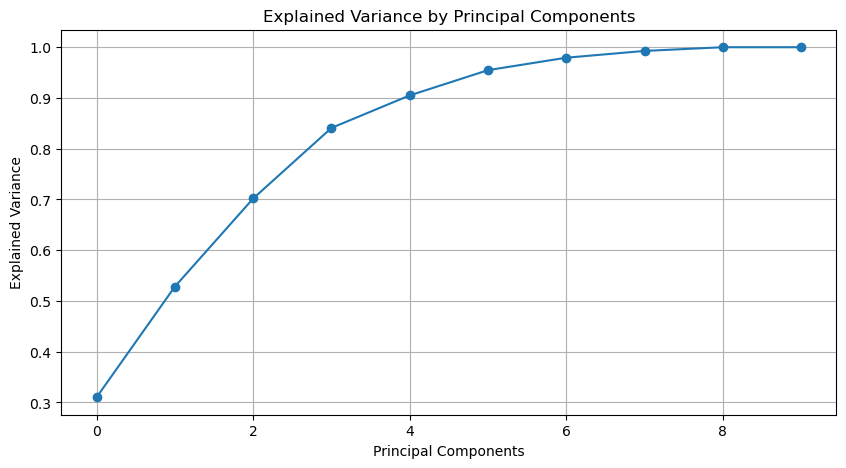

In [12]:
pca.get_cumu_var_plot()

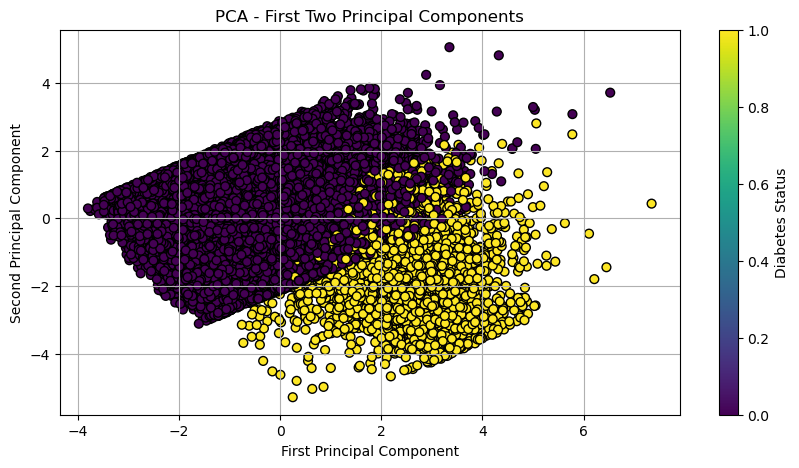

In [13]:
pca.get_firt_two_components_scatter_plot()

## 6 Prediction Model

### 6.1 Using Raw Features

In [14]:
# initialize model training
logistic_raw = LogisticModel(projectdf_nor.features, projectdf_nor.target)
# train the model
model = logistic_raw.logistic_training(test_size=0.2, random_state=RANDOM_STATE)
# evaluate the model
logistic_raw.evaluate(model)

,precision,recall,f1-score,support
Negative Diagnosis,0.9851,0.9064,0.9441,18222.0000
Positive Diagnosis,0.4720,0.8592,0.6093,1775.0000
accuracy,0.9022,0.9022,0.9022,0.9022
macro avg,0.7285,0.8828,0.7767,19997.0000
weighted avg,0.9395,0.9022,0.9144,19997.0000


> With imbalanced datasets, the accuracy score can be misleading. In this specific case, the ultimate goal of our logistic regression model is to identify most of the true positive cases of diabetes while maintaining a precision rate that is significantly higher than the general prevalence of diabetes in the population, which is 8.5%.

In [15]:
logistic_raw.get_model_expression(model)


### Logistic Regression Equation (logit):
$
\text{logit}(p) = -5.331\\ + 0.253 \cdot \text{Gender}\\ + 0.788 \cdot \text{Hypertension}\\ + 0.691 \cdot \text{Heart Disease}\\ + 0.172 \cdot \text{Smoking History Current}\\ + 0.050 \cdot \text{Smoking History Ever}\\  -0.222 \cdot \text{Smoking History Never}\\ + 1.031 \cdot \text{Age}\\ + 0.596 \cdot \text{Bmi}\\ + 2.501 \cdot \text{Hba1c Level}\\ + 1.342 \cdot \text{Blood Glucose Level}\\
$

### Logistic Regression Equation (probability):
$
p = \frac{1}{1 + e^\text{logit(p)}}
$


### 6.2 Use Pricinpal Components to reduce dimensions

#### using first five components (cumulatively account for 90% Variance)

In [16]:
pc_df = pca.get_project_principal_components_dataframe()

In [17]:
# initialize the model
logistic_pca = LogisticModel(pc_df.features.iloc[:, :5], pc_df.target)
# train the model
model = logistic_pca.logistic_training(test_size=0.2, random_state=RANDOM_STATE)
# evaluate the model
logistic_pca.evaluate(model)

,precision,recall,f1-score,support
Negative Diagnosis,0.9840,0.9030,0.9417,18222.0000
Positive Diagnosis,0.4602,0.8490,0.5968,1775.0000
accuracy,0.8982,0.8982,0.8982,0.8982
macro avg,0.7221,0.8760,0.7693,19997.0000
weighted avg,0.9375,0.8982,0.9111,19997.0000


In [18]:
logistic_pca.get_model_expression(model)


### Logistic Regression Equation (logit):
$
\text{logit}(p) = -5.180\\ + 2.507 \cdot \text{No 1 pricinpal component}\\  -1.689 \cdot \text{No 2 pricinpal component}\\ + 0.817 \cdot \text{No 3 pricinpal component}\\  -0.269 \cdot \text{No 4 pricinpal component}\\ + 0.076 \cdot \text{No 5 pricinpal component}\\
$

### Logistic Regression Equation (probability):
$
p = \frac{1}{1 + e^\text{logit(p)}}
$


#### using first two components (cumulatively account for 50% Variance)

>While retaining components that explain a high cumulative variance captures most of the information in the features, fewer components can still be effective if the variance they capture is more related to the prediction target.

In [19]:
# initialize the model
logistic_pca = LogisticModel(pc_df.features.iloc[:, :2], pc_df.target)
# train the model
model = logistic_pca.logistic_training(test_size=0.2, random_state=RANDOM_STATE)
# evaluate the model
logistic_pca.evaluate(model)

,precision,recall,f1-score,support
Negative Diagnosis,0.9837,0.9011,0.9406,18222.0000
Positive Diagnosis,0.4546,0.8468,0.5916,1775.0000
accuracy,0.8962,0.8962,0.8962,0.8962
macro avg,0.7192,0.8739,0.7661,19997.0000
weighted avg,0.9367,0.8962,0.9096,19997.0000


### 6.3 Non-invasive model

>We need to consider the availability of the features.
>HbA1c_level, blood_glucose_level require invasive medical tests to get, while other features are more easily accessible
>So we also built a model without these two features to serve as a basic version of the model

In [20]:
# get the normalized data without invasive features
df_nor_noninvasive = projectdf_nor.get_data().drop(columns=INVASIVES, inplace=False)
# instantiate the ProjectDataFrameNormalized object
projectdf_nor_noninvasive = ProjNormalizedDF(df_nor_noninvasive)

In [21]:
# initialize the model
logistic_pca = LogisticModel(projectdf_nor_noninvasive.features, projectdf_nor_noninvasive.target)
# train the model
model = logistic_pca.logistic_training(test_size=0.2, random_state=RANDOM_STATE)
# evaluate the model
logistic_pca.evaluate(model, prob_threshhold=0.085)

,precision,recall,f1-score,support
Negative Diagnosis,0.9738,0.7175,0.8262,18222.0000
Positive Diagnosis,0.2166,0.8017,0.3410,1775.0000
accuracy,0.7250,0.7250,0.7250,0.7250
macro avg,0.5952,0.7596,0.5836,19997.0000
weighted avg,0.9066,0.7250,0.7831,19997.0000
